In [86]:
using Plots, LaTeXStrings, JuMP, Ipopt, Statistics, JLD2
include("solar_insolation.jl");
using .SolarInsolationModel

In [99]:
# Vehicle Parameters
Base.@kwdef struct ASV_Params
    b_max::Float32 = 6500; # max soc in Wh
    b_min::Float32 = 0; # min soc in Wh
    panel_area::Float32 = 4; # m^2
    panel_efficiency::Float32 = 0.25; # 25% panel efficiency
    v_max::Float32 = 2.315; # max boat speed in m/s 
    v_min::Float32 = 0; # min boat speed in m/s

    k_h::Float32 = 10; # Hotel Load
    k_m::Float32 = 83; # Motor multiplier, need to tune
end

boat = ASV_Params();

# Environment Parameters
lat = 35.0; # degrees
Δt = 0.1; # time step in hours
t = 0:Δt:24;
og_time = t;
t = t .+ 12;
t = t .% 24; # time over a day from noon to noon
n = length(t);

# Common Initial Conditions/Parameters
b_0 = boat.b_max/2;
num_iters = 365;
δ = 150; # barrier dampening zone

[ Info: Saved animation to /home/kmgovind/Documents/research/cps/characterizing-ive/fig/dailyirradiance.gif


Plots.AnimatedGif("/home/kmgovind/Documents/research/cps/characterizing-ive/fig/dailyirradiance.gif")
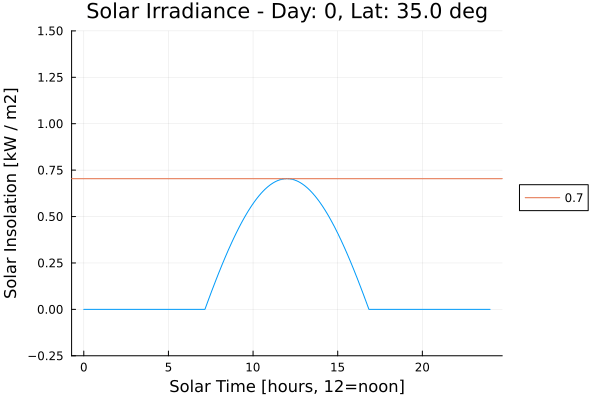

In [100]:
dailyirradiance = @animate for dayOfYear = 0:365
    # plot(solarTime -> SolarInsolationModel.SolarInsolation(dayOfYear, solarTime, lat), 0, 24, linestyle=:dash, label="Mathematical")
    # plot!(solarTime -> max(0, SolarInsolationModel.SolarInsolation(dayOfYear, solarTime, lat)), 0, 24, label="Actual")
    plot(solarTime -> max(0, SolarInsolationModel.SolarInsolation(dayOfYear, solarTime, lat)), 0, 24, label=false)
    maxsun = SolarInsolationModel.SolarInsolation(dayOfYear, 12, lat);
    hline!([maxsun], label="$(round(maxsun, digits=2))");
    plot!(legend=:outerright);
    xlabel!("Solar Time [hours, 12=noon]")
    ylabel!("Solar Insolation [kW / m2]")
    title!("Solar Irradiance - Day: $(dayOfYear), Lat: $(lat) deg")
    ylims!(-0.25, 1.5)
end
gif(dailyirradiance, joinpath("fig", "dailyirradiance.gif"))

# Iterative $v_{unc}$ with "PD control"

In [151]:
# Learning Gains
# k_p = 3e-5; # Learning P gain (-1e-5)
# k_d = -1e-8; # Learning D gain 5e-5

if num_iters <= 100
    k_p = 7e-5; # Learning P gain (1e-5)
    k_d = 1e-5; # Learning D gain 5e-5
else
    k_p = 7e-6; # Learning P gain (1e-5)
    k_d = 1e-8; # Learning D gain 5e-5
end

b_target = b_0; # target SOC at end of day

[ Info: Saved animation to /home/kmgovind/Documents/research/cps/characterizing-ive/ilc_fixed_target_sim.gif


Plots.AnimatedGif("/home/kmgovind/Documents/research/cps/characterizing-ive/ilc_fixed_target_sim.gif")
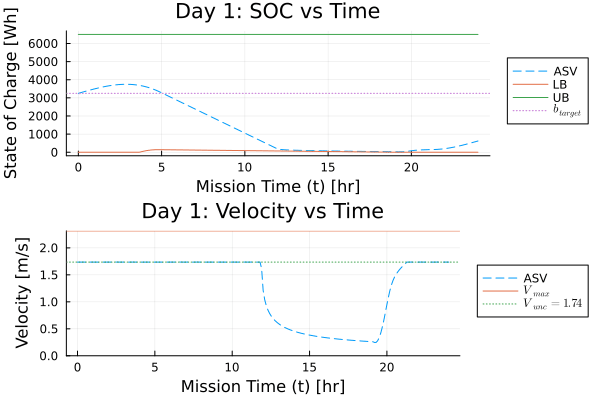

In [152]:
function batterymodel!(boat, dayOfYear, time, lat, vel, soc, dt)
    # Solar Insolation returns in kW
    p_in = max(0,SolarInsolationModel.SolarInsolation(dayOfYear, time, lat))* 1000 * boat.panel_area * boat.panel_efficiency;
    p_out = boat.k_h + boat.k_m * (vel^3);
    soc_est = soc + (p_in - p_out)*dt; # power update in Wh
    soc_est = min(soc_est, boat.b_max); # cap charge at soc_max
    return soc_est;
end

function powermodel!(boat, dayOfYear, time, lat, vel, soc, dt)
    # Solar Insolation returns in kW
    p_in = max(0,SolarInsolationModel.SolarInsolation(dayOfYear, time, lat))* 1000 * boat.panel_area * boat.panel_efficiency;
    p_out = boat.k_h + boat.k_m * (vel^3);
    out = p_in - p_out;
    return out;
end

function zeropower!(boat, dayOfYear, time, lat, soc, dt)
    p_in = max(0,SolarInsolationModel.SolarInsolation(dayOfYear, time, lat))* 1000 * boat.panel_area * boat.panel_efficiency;
    if p_in < boat.k_h
        vel = 0;
    else
        vel = cbrt((p_in - boat.k_h)/boat.k_m);
    end
    return vel;
end

global v_list_ilc = zeros(num_iters, n);
global b_list_ilc = zeros(num_iters, n);
global x_list_ilc = zeros(num_iters, n);
global error_list_ilc = zeros(num_iters);
global error_rate_ilc = zeros(num_iters);
v_unc = boat.v_max*(0.75); # Initial guess for v_unc
v_list_ilc[1, :] .= v_unc;


# Initial conditions Day 1
x = zeros(n);
b = ones(n)*b_0;
v = ones(n)*boat.v_max;
old_b = zeros(n);

simulation = @animate for dayOfYear = 1:1:num_iters

    # Initialize state variables
    v_unc = v_list_ilc[dayOfYear, 1];
    global x = zeros(n);
    global b = ones(n)*b[end];
    global v = ones(n)*v_unc;

    # Compute SOC Boundaries
    ϵ₋ = zeros(n); # energy deficit
    Pd = zeros(n);
    ϵ₊ = zeros(n); # energy surplus
    Ps = zeros(n);
    global lcbf = zeros(n);
    global ucbf = zeros(n);
    for i = 1:n
        # Lower SOC boundary
        Pd[i] = max(0, SolarInsolationModel.SolarInsolation(dayOfYear, t[i], lat))*1000* boat.panel_area * boat.panel_efficiency;
        ϵ₋[i] = boat.k_h*(og_time[i] - og_time[1]) - sum(Pd[1:i]*Δt);
        

        # Upper SOC boundary
        Ps[i] = max(0, SolarInsolationModel.SolarInsolation(dayOfYear, t[i], lat))*1000* boat.panel_area * boat.panel_efficiency;
        ϵ₊[i] = sum(Ps[1:i]*Δt) - (boat.k_h + boat.k_m*(boat.v_max^3))*(og_time[i] - og_time[1]);
        
    end

    for i = 1:n
        ϵ₋dag = ϵ₋ .- ϵ₋[i];
        global lcbf[i] = max(0, maximum(ϵ₋dag[i:end]));
        ϵ₊dag = ϵ₊ .- ϵ₊[i];
        global ucbf[i] = boat.b_max - max(0, maximum(ϵ₊dag[i:end]));
    end


    for j in 2:n
        i = j-1;

        # Compute unconstrained velocity and SOC
        global v[i] = v_unc;
        b_dot = powermodel!(boat, dayOfYear, t[i], lat, v[i], b[i], Δt);

        # Impose Boundary Conditions
        if b[i] <= lcbf[i]
            global v[i] = 0;
        elseif 0 < (b[i] - lcbf[i]) < δ
            global v[i] = (b[i] - lcbf[i])/δ * v[i] + (1 - (b[i] - lcbf[i])/δ) * boat.v_min;
        elseif b[i] >= ucbf[i]
            global v[i] = boat.v_max;
        elseif 0 < (ucbf[i] - b[i]) < δ
            global v[i] = (ucbf[i] - b[i])/δ * v[i] + (1 - (ucbf[i] - b[i])/δ) * boat.v_max;
        end

        # Move boat
        global x[j] = x[i] + (v[i] * 60 * 60) * Δt;
        global b[j] = batterymodel!(boat, dayOfYear, t[i], lat, v[i], b[i], Δt);
        global v[j] = v[i];

        # Continuous rate update
        if dayOfYear != 1
            cont_error = b[j] - b_list_ilc[dayOfYear-1, j];
            v_unc =  v_list_ilc[dayOfYear-1, 1] + k_d * cont_error;
        end
    end

    # Store Data
    global b_list_ilc[dayOfYear, :] = b';
    global v_list_ilc[dayOfYear, :] = v';
    if dayOfYear == 1
        global x_list_ilc[dayOfYear, :] = x';
    else
        global x_list_ilc[dayOfYear, :] = x_list_ilc[dayOfYear - 1, end] .+ x';
    end

    # Learning adjustment
    if dayOfYear < num_iters
        global error_rate_ilc[dayOfYear] = 0;
        global error_list_ilc[dayOfYear] = b[end] - b_target;
        if dayOfYear != 1
            global error_rate_ilc[dayOfYear] = error_list_ilc[dayOfYear] - error_list_ilc[dayOfYear-1];
        end
        global v_list_ilc[dayOfYear + 1, 1] = v_list_ilc[dayOfYear, 1] + k_p * error_list_ilc[dayOfYear];
    end


    # Plot SOC vs Time
    plot(og_time, b, linestyle=:dash, label="ASV");
    plot!(og_time, lcbf, label="LB");
    plot!(og_time, ucbf, label="UB");
    hline!([b_target], linestyle=:dot, label=L"$b_{target}$");
    xlabel!("Mission Time (t) [hr]");
    ylabel!("State of Charge [Wh]");
    title!("Day $(dayOfYear): SOC vs Time");
    p1 = plot!(legend=:outerright)

    # Plot Velocity vs Time
    plot(og_time, v, linestyle=:dash, label="ASV");
    hline!([boat.v_max], label=L"$V_{max}$");
    hline!([v_unc], linestyle=:dot, label=L"V_{unc} = %$(round(v_unc, digits=2))");
    ylims!(0, boat.v_max);
    xlabel!("Mission Time (t) [hr]");
    ylabel!("Velocity [m/s]");
    title!("Day $(dayOfYear): Velocity vs Time");
    p2 = plot!(legend=:outerright)

    
    # Subplot
    plot(p1, p2, layout=(2,1))


    if dayOfYear == 180
        savefig("fig/day180velprofile.png")
    end

end
gif(simulation, "fig/ilc_fixed_target_sim.gif")

# Constant velocity over the year

$$
P_{out} = (k_h + k_m u^3)  t
$$

In [153]:
# Add up all the solar Irradiance
powerin = 0;
for dayOfYear = 0:365
    for i = 1:n
        pin = max(0, SolarInsolationModel.SolarInsolation(dayOfYear, t[i], lat))*1000* boat.panel_area * boat.panel_efficiency;
        powerin += pin*Δt;
    end
end

# total time in hours
yr2hrs = 24 * 365;
num = (powerin/yr2hrs) - boat.k_h;
# yearlongvel = cbrt(num/boat.k_m)

yearlongvel = 1.285
# yearlongvel = 1.85

1.285

[ Info: Saved animation to /home/kmgovind/Documents/research/cps/characterizing-ive/constant_vel_sim.gif


Plots.AnimatedGif("/home/kmgovind/Documents/research/cps/characterizing-ive/constant_vel_sim.gif")
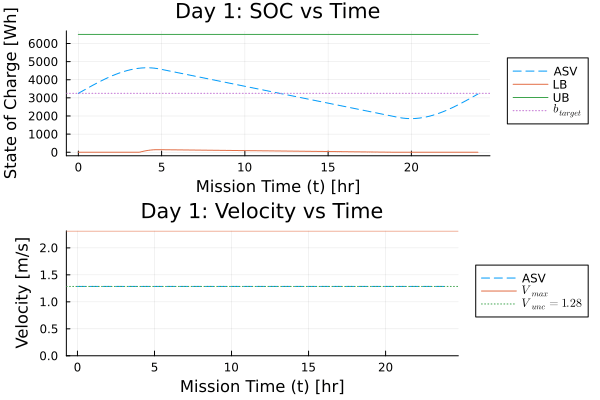

In [154]:
function batterymodel!(boat, dayOfYear, time, lat, vel, soc, dt)
    # Solar Insolation returns in kW
    p_in = max(0,SolarInsolationModel.SolarInsolation(dayOfYear, time, lat))* 1000 * boat.panel_area * boat.panel_efficiency;
    p_out = boat.k_h + boat.k_m * (vel^3);
    soc_est = soc + (p_in - p_out)*dt; # power update in Wh
    soc_est = min(soc_est, boat.b_max); # cap charge at soc_max
    return soc_est;
end

function powermodel!(boat, dayOfYear, time, lat, vel, soc, dt)
    # Solar Insolation returns in kW
    p_in = max(0,SolarInsolationModel.SolarInsolation(dayOfYear, time, lat))* 1000 * boat.panel_area * boat.panel_efficiency;
    p_out = boat.k_h + boat.k_m * (vel^3);
    out = p_in - p_out;
    return out;
end

function zeropower!(boat, dayOfYear, time, lat, soc, dt)
    p_in = max(0,SolarInsolationModel.SolarInsolation(dayOfYear, time, lat))* 1000 * boat.panel_area * boat.panel_efficiency;
    if p_in < boat.k_h
        vel = 0;
    else
        vel = cbrt((p_in - boat.k_h)/boat.k_m);
    end
    return vel;
end

v_unc = yearlongvel; # Initial guess for v_unc
global v_list_const = ones(num_iters, n)*v_unc;
global b_list_const = zeros(num_iters, n);
global x_list_const = zeros(num_iters, n);


# Initial conditions Day 1
x = zeros(n);
b = ones(n)*b_0;
v = ones(n)*yearlongvel;
old_b = zeros(n);

simulation = @animate for dayOfYear = 1:1:num_iters

    # Initialize state variables
    v_unc = yearlongvel;
    # v_list[dayOfYear] = v_unc;
    global x = zeros(n);
    global b = ones(n)*b[end];
    global v = ones(n)*v_unc;

    # Compute SOC Boundaries
    ϵ₋ = zeros(n); # energy deficit
    Pd = zeros(n);
    ϵ₊ = zeros(n); # energy surplus
    Ps = zeros(n);
    global lcbf = zeros(n);
    global ucbf = zeros(n);
    for i = 1:n
        # Lower SOC boundary
        Pd[i] = max(0, SolarInsolationModel.SolarInsolation(dayOfYear, t[i], lat))*1000* boat.panel_area * boat.panel_efficiency;
        ϵ₋[i] = boat.k_h*(og_time[i] - og_time[1]) - sum(Pd[1:i]*Δt);
        

        # Upper SOC boundary
        Ps[i] = max(0, SolarInsolationModel.SolarInsolation(dayOfYear, t[i], lat))*1000* boat.panel_area * boat.panel_efficiency;
        ϵ₊[i] = sum(Ps[1:i]*Δt) - (boat.k_h + boat.k_m*(boat.v_max^3))*(og_time[i] - og_time[1]);
        
    end

    for i = 1:n
        ϵ₋dag = ϵ₋ .- ϵ₋[i];
        global lcbf[i] = max(0, maximum(ϵ₋dag[i:end]));
        ϵ₊dag = ϵ₊ .- ϵ₊[i];
        global ucbf[i] = boat.b_max - max(0, maximum(ϵ₊dag[i:end]));
    end

    # Propagate Dynamics
    for j in 2:n
        i = j-1;

        # Compute unconstrained velocity and SOC
        global v[i] = yearlongvel;
        b_dot = powermodel!(boat, dayOfYear, t[i], lat, v[i], b[i], Δt);

        # Impose Boundary Conditions
        if b[i] <= lcbf[i]
            global v[i] = 0;
        elseif 0 < (b[i] - lcbf[i]) < δ
            global v[i] = (b[i] - lcbf[i])/δ * v[i] + (1 - (b[i] - lcbf[i])/δ) * boat.v_min;
        elseif b[i] >= ucbf[i]
            global v[i] = boat.v_max;
        elseif 0 < (ucbf[i] - b[i]) < δ
            global v[i] = (ucbf[i] - b[i])/δ * v[i] + (1 - (ucbf[i] - b[i])/δ) * boat.v_max;
        end

        # Move boat
        global x[j] = x[i] + (v[i] * 60 * 60) * Δt;
        global b[j] = batterymodel!(boat, dayOfYear, t[i], lat, v[i], b[i], Δt);
        global v[j] = v[i];

    end

    global b_list_const[dayOfYear, :] = b';
    global v_list_const[dayOfYear, :] = v';
    if dayOfYear == 1
        global x_list_const[dayOfYear, :] = x';
    else
        global x_list_const[dayOfYear, :] = x_list_const[dayOfYear - 1, end] .+ x';
    end

    # Plot SOC vs Time
    plot(og_time, b, linestyle=:dash, label="ASV");
    plot!(og_time, lcbf, label="LB");
    plot!(og_time, ucbf, label="UB");
    hline!([b_target], linestyle=:dot, label=L"$b_{target}$");
    xlabel!("Mission Time (t) [hr]");
    ylabel!("State of Charge [Wh]");
    title!("Day $(dayOfYear): SOC vs Time");
    p1 = plot!(legend=:outerright)

    # Plot Velocity vs Time
    plot(og_time, v, linestyle=:dash, label="ASV");
    hline!([boat.v_max], label=L"$V_{max}$");
    hline!([v_unc], linestyle=:dot, label=L"V_{unc} = %$(round(v_unc, digits=2))");
    ylims!(0, boat.v_max);
    xlabel!("Mission Time (t) [hr]");
    ylabel!("Velocity [m/s]");
    title!("Day $(dayOfYear): Velocity vs Time");
    p2 = plot!(legend=:outerright)

    
    # Subplot
    plot(p1, p2, layout=(2,1))

    # if dayOfYear == 180
    #     savefig("fig/day180velprofile.png")
    # end
end
gif(simulation, "fig/constant_vel_sim.gif")

# Constant Unconstrained Velocity

In [155]:
# Add up all the solar Irradiance
powerin = 0;
for dayOfYear = 0:365
    for i = 1:n
        pin = max(0, SolarInsolationModel.SolarInsolation(dayOfYear, t[i], lat))*1000* boat.panel_area * boat.panel_efficiency;
        powerin += pin*Δt;
    end
end

# total time in hours
yr2hrs = 24 * 365;
num = (powerin/yr2hrs) - boat.k_h;
yearlongvel = cbrt(num/boat.k_m)

1.6192551330918281

[ Info: Saved animation to /home/kmgovind/Documents/research/cps/characterizing-ive/constant_vel_unconstrained_sim.gif


Plots.AnimatedGif("/home/kmgovind/Documents/research/cps/characterizing-ive/constant_vel_unconstrained_sim.gif")
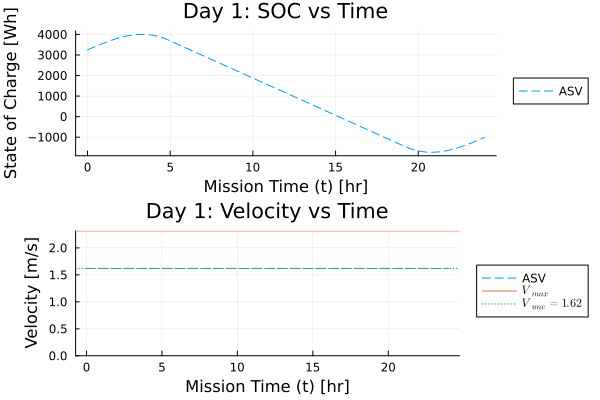

In [156]:
function batterymodel!(boat, dayOfYear, time, lat, vel, soc, dt)
    # Solar Insolation returns in kW
    p_in = max(0,SolarInsolationModel.SolarInsolation(dayOfYear, time, lat))* 1000 * boat.panel_area * boat.panel_efficiency;
    p_out = boat.k_h + boat.k_m * (vel^3);
    soc_est = soc + (p_in - p_out)*dt; # power update in Wh
    # soc_est = min(soc_est, boat.b_max); # cap charge at soc_max
    return soc_est;
end

function powermodel!(boat, dayOfYear, time, lat, vel, soc, dt)
    # Solar Insolation returns in kW
    p_in = max(0,SolarInsolationModel.SolarInsolation(dayOfYear, time, lat))* 1000 * boat.panel_area * boat.panel_efficiency;
    p_out = boat.k_h + boat.k_m * (vel^3);
    out = p_in - p_out;
    return out;
end

function zeropower!(boat, dayOfYear, time, lat, soc, dt)
    p_in = max(0,SolarInsolationModel.SolarInsolation(dayOfYear, time, lat))* 1000 * boat.panel_area * boat.panel_efficiency;
    if p_in < boat.k_h
        vel = 0;
    else
        vel = cbrt((p_in - boat.k_h)/boat.k_m);
    end
    return vel;
end

v_unc = yearlongvel;
global v_list_unc = ones(num_iters, n)*v_unc;
global b_list_unc = zeros(num_iters, n);
global x_list_unc = zeros(num_iters, n);


# Initial conditions Day 1
x = zeros(n);
b = ones(n)*b_0;
v = ones(n)*yearlongvel;
old_b = zeros(n);


simulation = @animate for dayOfYear = 1:1:num_iters

    # Initialize state variables
    v_unc = v_list_unc[dayOfYear, 1];
    global x = zeros(n);
    global b = ones(n)*b[end];
    global v = ones(n)*v_unc;

    # Propagate Dynamics
    for j in 2:n
        i = j-1;

        # Compute unconstrained velocity and SOC
        global v[i] = yearlongvel;
        p_in = powermodel!(boat, dayOfYear, t[i], lat, v[i], b[i], Δt);
        p_out = boat.k_h + boat.k_m * (v[i]^3);
        b_dot = p_in - p_out;

        # Move boat
        global x[j] = x[i] + (v[i] * 60 * 60) * Δt;
        global b[j] = batterymodel!(boat, dayOfYear, t[i], lat, v[i], b[i], Δt);
        global v[j] = v[i];
    end

    # Store Data
    global b_list_unc[dayOfYear, :] = b';
    global v_list_unc[dayOfYear, :] = v';
    if dayOfYear == 1
        global x_list_unc[dayOfYear, :] = x';
    else
        global x_list_unc[dayOfYear, :] = x_list_unc[dayOfYear - 1, end] .+ x';
    end

    # Plot SOC vs Time
    plot(og_time, b, linestyle=:dash, label="ASV");
    # plot!(og_time, lcbf, label="LB");
    # plot!(og_time, ucbf, label="UB");
    xlabel!("Mission Time (t) [hr]");
    ylabel!("State of Charge [Wh]");
    title!("Day $(dayOfYear): SOC vs Time");
    p1 = plot!(legend=:outerright)

    # Plot Velocity vs Time
    plot(og_time, v, linestyle=:dash, label="ASV");
    hline!([boat.v_max], label=L"$V_{max}$");
    hline!([yearlongvel], linestyle=:dot, label=L"V_{unc} = %$(round(yearlongvel, digits=2))");
    ylims!(0, boat.v_max);
    xlabel!("Mission Time (t) [hr]");
    ylabel!("Velocity [m/s]");
    title!("Day $(dayOfYear): Velocity vs Time");
    p2 = plot!(legend=:outerright)
    
    # Subplot
    plot(p1, p2, layout=(2,1))

end
gif(simulation, "fig/constant_vel_unconstrained_sim.gif")

# Data Comparison

The full MPC implementation is in `mpc_model_irr.jl` to aid with ease of execution.

We first compare the distance traveled:

In [157]:
mpc_iters = 14;

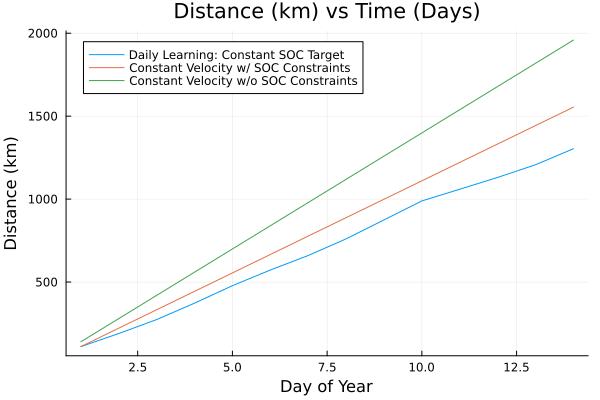

In [158]:
plot(x_list_ilc[1:mpc_iters,end]./1000, label="Daily Learning: Constant SOC Target");
plot!(x_list_const[1:mpc_iters,end]./1000, label="Constant Velocity w/ SOC Constraints");
plot!(x_list_unc[1:mpc_iters,end]./1000, label="Constant Velocity w/o SOC Constraints");
xlabel!("Day of Year");
ylabel!("Distance (km)");
title!("Distance (km) vs Time (Days)");
plot!()
# savefig("fig/strat_comparison.png")

In [159]:
# Load in save data from `mpc_model_irr.jl`
@load "mpc_comp.jld2"

4-element Vector{Symbol}:
 :x_list_mpc
 :b_list_mpc
 :v_list_mpc
 :og_time

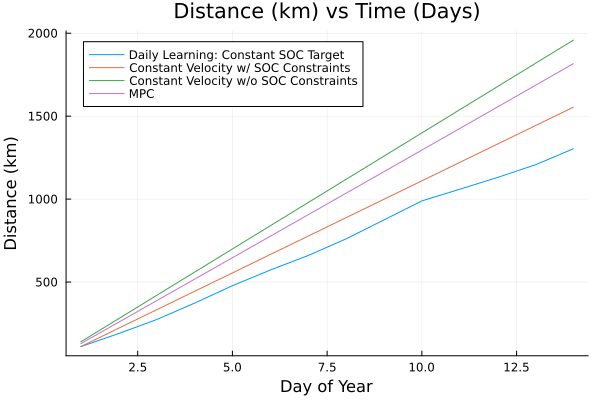

In [160]:
plot!(x_list_mpc[1:mpc_iters,end]./1000, label="MPC")